Imports

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier



Hyperparameters

In [2]:
std_tol = 150
cov_tol = 0.66
n_clusters = 21
N = 5250 # Amount of data we want to use max: 5250

Import Data

In [75]:
def to_onehot(x):
    labels = np.unique(x)
    result = np.zeros(shape=(x.shape[0], labels.shape[0]))

    for i in range(len(x)):
        result[i][x[i]] = 1.0

    return result

def split_data(X, y, test_size=0.2, val_size=0.2):
   
    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Further splitting the training data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size / (1 - test_size))

    return X_train, X_val, X_test, y_train, y_val, y_test


In [76]:
X = [] # Features per class
y = [] # Labels

# Import the features
with open("traindata.txt", "r") as file:
    for line in file.readlines()[:N]:
        features = [float(i) for i in line.split(",")]
        X.append(features)

# Import the labels
with open("trainlabels.txt", "r") as file:
    for line in file.readlines()[:N]:
        label = float(line.rstrip())
        y.append(label)
    
# Convert data to numpy arrays
X = np.array(X)
y = np.array(y, dtype=np.int32)

##### Augment Data

In [77]:
!pip install imbalanced-learn

SMOTE (Synthetic Minority Oversampling Technique) - over-sample minority classes i.e even out number of datapoints per class

In [106]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

print("Before: ")
print("X shape:", X.shape)
print("y shape:", y.shape, end="\n\n")

X_resampled, y_resampled = smote.fit_resample(X, y)

print("After: ")
print("X shape:", X_resampled.shape)
print("y shape:", y_resampled.shape, end="\n\n")


Before: 
X shape: (5250, 1041)
y shape: (5250,)

After: 
X shape: (5922, 1041)
y shape: (5922,)



Split Data

In [107]:
# Raw data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_resampled, y_resampled, 0.2, 0.1)
# Onehot data
y_train_onehot, y_test_onehot, y_val_onehot = to_onehot(y_train), to_onehot(y_test), to_onehot(y_val)

Principal Component Analysis

In [108]:
# Calculates the number of components to consider when performing pca
def num_components(X, variance_tol = 0.8):
    # Standardize each feature of the matrix
    x_mean = np.mean(X, axis = 0)
    x_std = np.std(X, axis = 0)
    Z = normalize_data(X, x_mean, x_std)

    # Calculate covariance matrix
    C = np.cov(Z, rowvar=False)
    # Calculate eigenvalues and eigenvectors and sort by size
    eigenvalues, eigenvectors = np.linalg.eig(C)
    index = eigenvalues.argsort()[:: -1]
    eigenvalues = eigenvalues[index]
    eigenvectors = eigenvectors[:, index]

    # Calculate explained variance matrix 
    explained_var = np.cumsum(eigenvalues) / np.sum(eigenvalues)

    # Select number of components responsible for variance_tol% of variance
    n_components = np.argmax(explained_var >= variance_tol) + 1
    return Z, x_mean, x_std, n_components

def normalize_data(X, mean, std):
    return (X - mean)/std

def convert_to_pca(components, mean, std, X):
    Z = normalize_data(X, mean, std)
    return np.transpose(np.matmul(components, np.transpose(Z)))


In [109]:
Z, mean, std, n_components = num_components(X_train, cov_tol)
# Initialize prinicipal component analysis
pca = PCA(n_components)
pca.fit(Z)
components = pca.components_
# Data in PCA form
X_train_PCA = pca.transform(Z)
X_test_PCA = convert_to_pca(components, mean, std, X_test)
X_val_PCA = convert_to_pca(components, mean, std, X_val)


In [110]:
print(X_train_PCA.shape)

(4144, 45)


In [111]:
np.save("pca_utils/pca_components", components)
np.save("pca_utils/X_mean", mean)
np.save("pca_utils/X_std", std)

Feature Cover

In [112]:
def generate_feature_cover(X, std_tol = 500):
    x_mean = np.mean(X, axis = 0)
    x_std = np.std(X, axis = 0)
    feature_cover = np.zeros(len(x_mean), dtype = bool)

    for i in range(len(x_mean)):
        if np.abs(x_std[i]) < std_tol:
            feature_cover[i] = True    

    return feature_cover

# generate_feature_cover_correlation(X_train)

In [113]:
feature_cover = generate_feature_cover(X_train, std_tol)
# Data with feature cover
X_train_cover, X_test_cover, X_val_cover = X_train[:, feature_cover],  X_test[:, feature_cover],  X_val[:, feature_cover]

In [114]:
Z, mean, std, n_components = num_components(X_train_cover, cov_tol)
# Initialize prinicipal component analysis
pca = PCA(n_components)
pca.fit(Z)
components = pca.components_

# Data in covered PCA form
X_train_cover_PCA = pca.transform(Z)
X_test_cover_PCA = convert_to_pca(components, mean, std, X_test_cover)
X_val_cover_PCA = convert_to_pca(components, mean, std, X_val_cover)

Visualize Data

In [115]:
def scatterplot_matrix(X_train, y_train, n = 5):
    combined_data = np.hstack((np.transpose([y_train]), X_train[:, 0: n]))
    df = pd.DataFrame(combined_data)
    sns.pairplot(df, hue=0)

def get_correlations(X_train):
    df = pd.DataFrame(X_train)
    correlations = df.corr()
    return correlations

def heatmap(X_train, n = 5):
    correlations = get_correlations(X_train)

    sns.heatmap(correlations, annot=False)

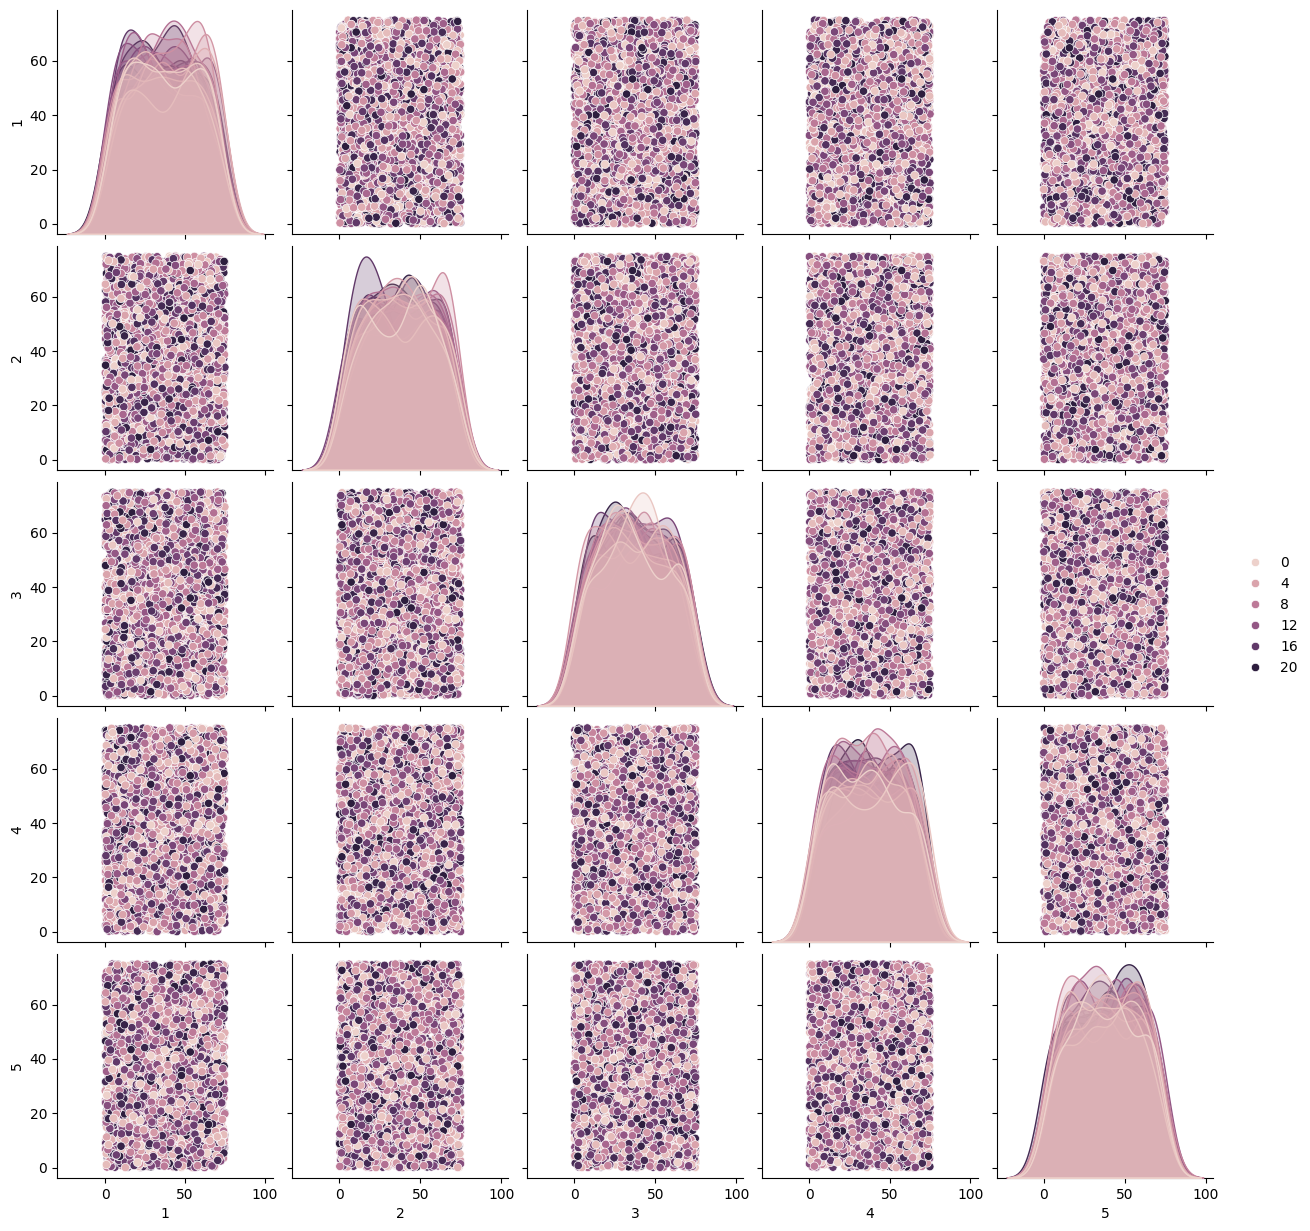

In [116]:
# Scatterplot matrices
# Visualize raw data
scatterplot_matrix(X_train, y_train, 5)

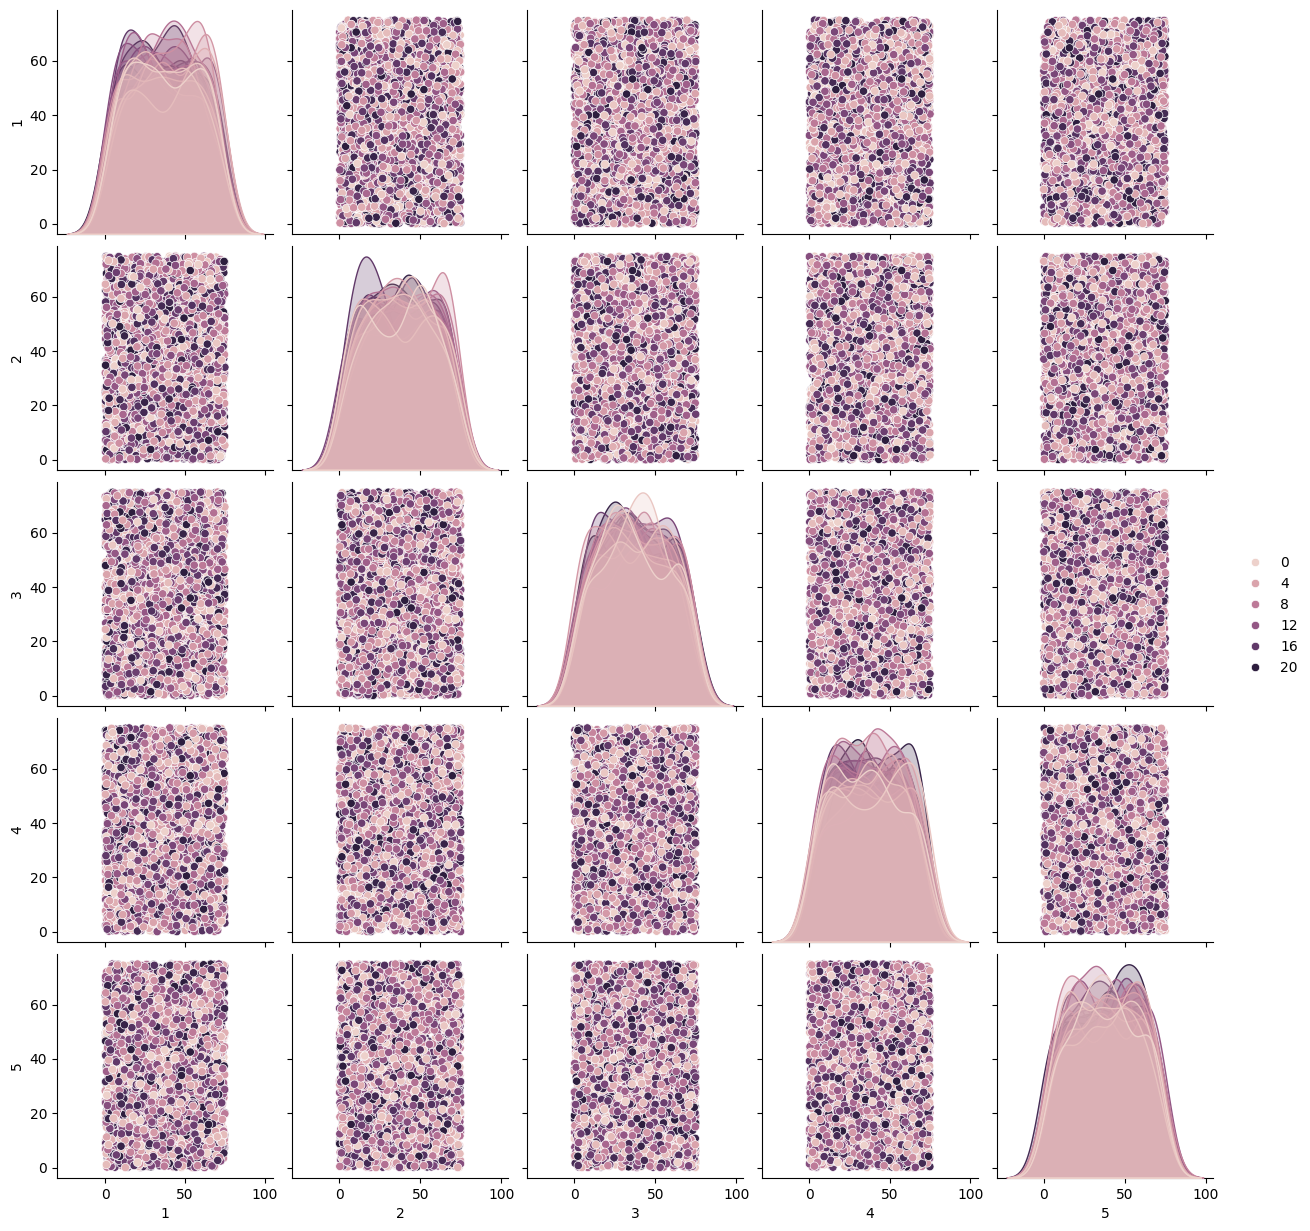

In [117]:
# Visualize covered data
scatterplot_matrix(X_train_cover, y_train, 5)

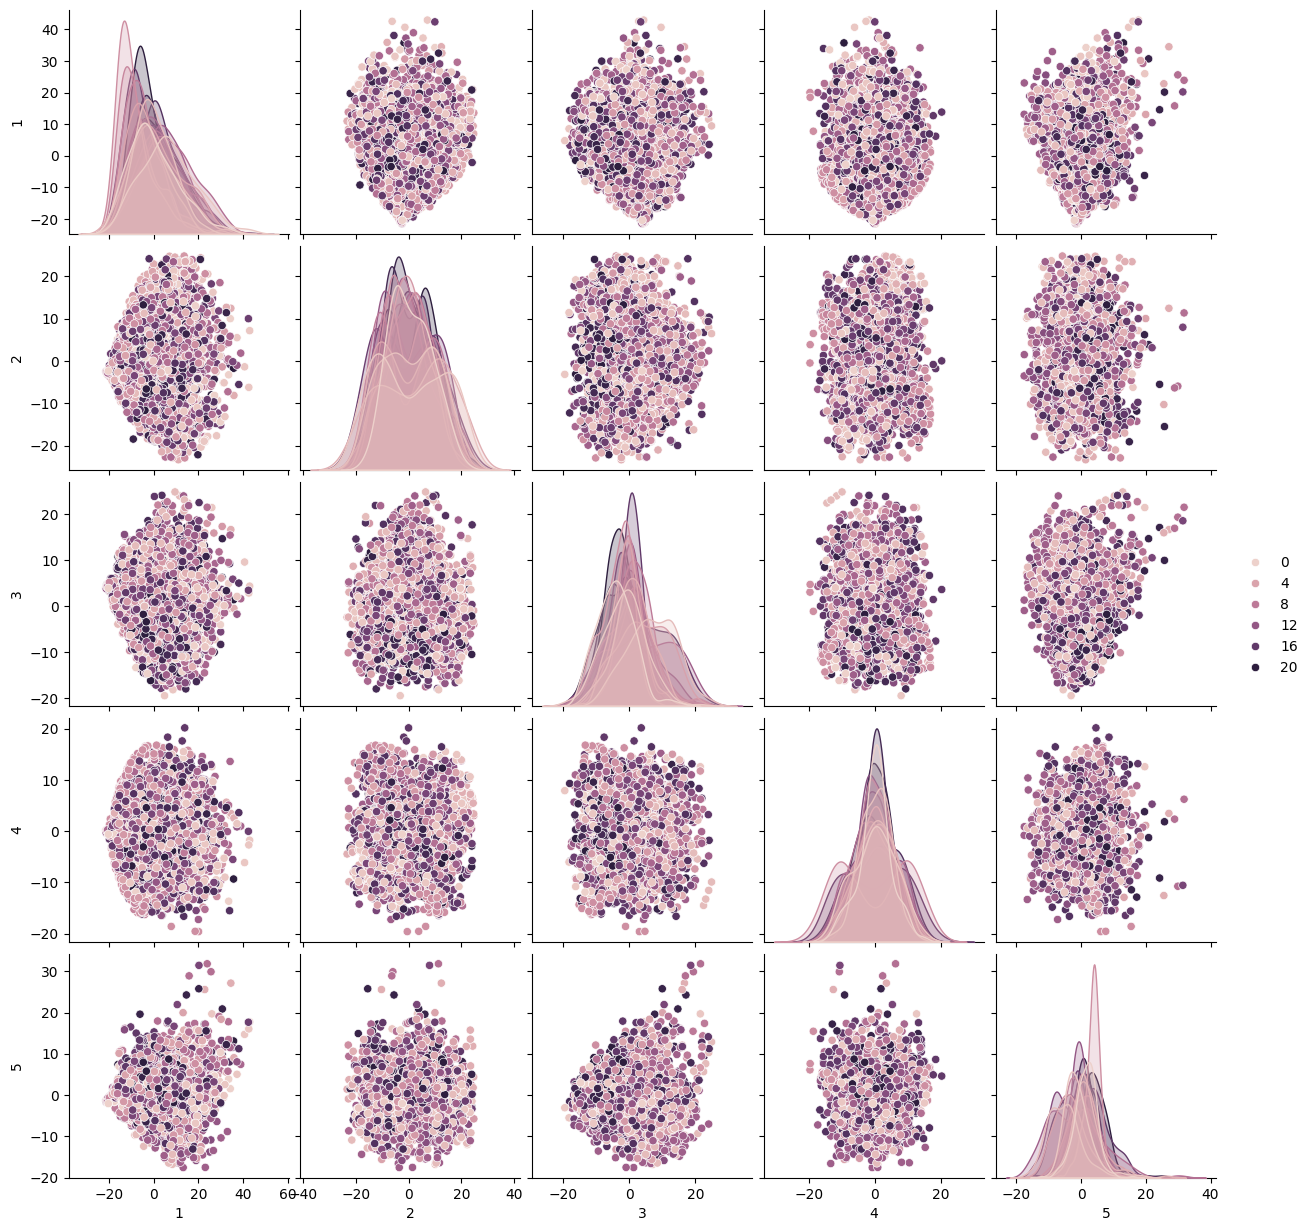

In [118]:
# Visualize PCA data
scatterplot_matrix(X_train_PCA, y_train, 5)

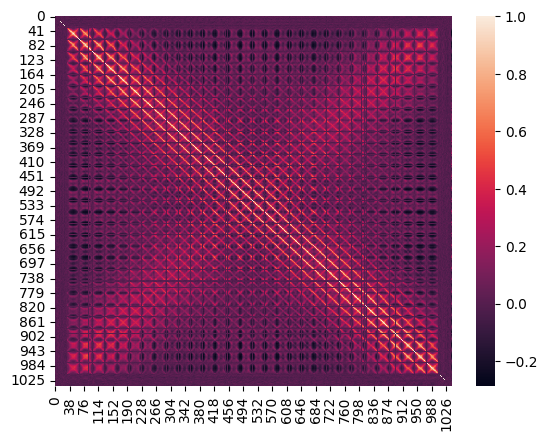

In [119]:
heatmap(X_train, len(X_train))

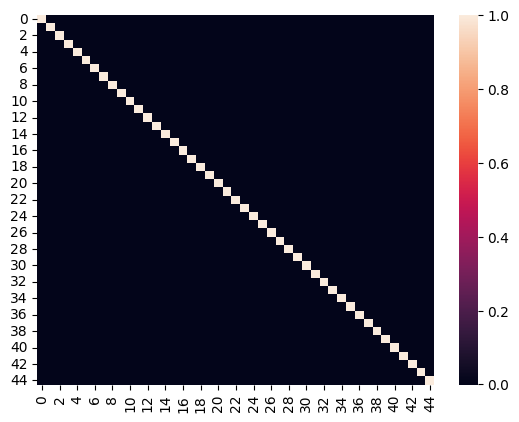

In [120]:
heatmap(X_train_PCA, len(X_train_PCA))

Clustering attempt

In [121]:
def cluster(X_train, X_test, n_clusters = 21):
      kmeans = KMeans(n_clusters)
      kmeans.fit(X_train)
      centroids = kmeans.cluster_centers_
      y_pred = kmeans.predict(X_test)
      return y_pred, centroids

In [122]:
# Cluster raw data
y_pred, centroids = cluster(X_train, X_test, n_clusters)

print("Raw Data:")
print("Number of mislabeled points out of a total %d points : %d"

      % (X_test.shape[0], (y_test != y_pred).sum()))

Raw Data:
Number of mislabeled points out of a total 1185 points : 1138


In [123]:
# Cluster covered data
y_pred, centroids = cluster(X_train_cover, X_test_cover, n_clusters)

print("Covered Data:")
print("Number of mislabeled points out of a total %d points : %d"

      % (X_test.shape[0], (y_test != y_pred).sum()))

Covered Data:
Number of mislabeled points out of a total 1185 points : 1109


In [124]:
# Cluster PCA data
y_pred, centroids = cluster(X_train_PCA, X_test_PCA, n_clusters)

print("PCA Data:")
print("Number of mislabeled points out of a total %d points : %d"

      % (X_test.shape[0], (y_test != y_pred).sum()))

PCA Data:
Number of mislabeled points out of a total 1185 points : 1133


Naive Bayes Attempt

In [125]:
def naive_bayes(X_train, y_train, X_test):
      gnb = GaussianNB()
      y_pred = gnb.fit(X_train, y_train).predict(X_test)
      return y_pred

def make_confusion_matrix_standard(y_test, y_pred):
      c_matrix = np.zeros((len(np.unique(y_test)), len(np.unique(y_test))))
      for i in range(len(y_test)):
            c_matrix[y_test[i], y_pred[i]] += 1
      return c_matrix

In [126]:
# Naive Bayes with raw data
y_pred = naive_bayes(X_train, y_train, X_test)
print("Raw Data:")
print("Number of mislabeled points out of a total %d points : %d"

      % (X_test.shape[0], (y_test != y_pred).sum()))


Raw Data:
Number of mislabeled points out of a total 1185 points : 902


In [127]:
# Naive Bayes with covered data
y_pred = naive_bayes(X_train_cover, y_train, X_test_cover)
print("Covered Data:")
print("Number of mislabeled points out of a total %d points : %d"

      % (X_test.shape[0], (y_test != y_pred).sum()))


Covered Data:
Number of mislabeled points out of a total 1185 points : 899


In [128]:
# Naive Bayes with PCA data
y_pred_nb = naive_bayes(X_train_PCA, y_train, X_test_PCA)
print("PCA Data:")
print("Number of mislabeled points out of a total %d points : %d"

      % (X_test.shape[0], (y_test != y_pred_nb).sum()))


PCA Data:
Number of mislabeled points out of a total 1185 points : 677


### Random Forest

In [129]:
n_estimators = 5000
clf = RandomForestClassifier(n_estimators=n_estimators, n_jobs = -1)

clf.fit(X_train_PCA, y_train)
y_pred_tree = clf.predict(X_test_PCA)

print("Number of mislabeled test points out of a total %d points : %d"
      % (X_test_PCA.shape[0], (y_test != y_pred_tree).sum()))


Number of mislabeled test points out of a total 1185 points : 476


#### Saving Model

In [131]:
import joblib
joblib.dump(clf, "clf.pkl")

['clf.pkl']

#### Loading Model

In [133]:
clf2 = joblib.load("clf.pkl")

y_pred_tree = clf2.predict(X_test_PCA)

print("Number of mislabeled test points out of a total %d points : %d"
      % (X_test_PCA.shape[0], (y_test != y_pred_tree).sum()))

Number of mislabeled test points out of a total 1185 points : 476


Neural Network

In [ ]:
# import torch as T
# import torch.nn as nn


# class NeuralNetwork(nn.Module):
#     def __init__(self, n_inputs, n_outputs, p_dropout=0.20, save_dir="./models"):
#         super(NeuralNetwork, self).__init__()
#         self.save_dir = save_dir

#         activation = nn.ReLU()
#         dropout = nn.Dropout(p=p_dropout)

#         self.network = nn.Sequential(
#             nn.Linear(in_features=n_inputs, out_features=n_inputs * 3),
#             activation,
#             dropout,
#             nn.Linear(in_features=n_inputs * 3, out_features=n_inputs * 2),
#             activation,
#             dropout,
#             nn.Linear(in_features=n_inputs * 2, out_features=n_inputs),
#             activation,
#             dropout,
#             nn.Linear(in_features=n_inputs, out_features=n_outputs),
#         )
    
#     def forward(self, X):
#         logits = self.network(X)
#         return logits
    
#     def save(self, name):
#         T.save(self.state_dict(), f"{self.save_dir}/{name}.pth")

#     def load(self, name):
#         self.load_state_dict(T.load(f"{self.save_dir}/{name}.pth"))


# def get_n_inputs(X_train):
#     return X_train.shape[1] 

# n_inputs = get_n_inputs(X_train_PCA)

# n_outputs = 21 # 21 labels

# # Move a tensor to the GPU
# device = T.device("cuda" if T.cuda.is_available() else "cpu")

# # Initialize the model
# model_1 = NeuralNetwork(n_inputs=n_inputs, n_outputs=n_outputs, p_dropout=0.2).to(device)
# model_2 = NeuralNetwork(n_inputs=n_inputs, n_outputs=n_outputs, p_dropout=0.2).to(device)

In [ ]:
# def make_confusion_matrix(y_pred, y_true, labels):
#     N = labels.shape[0]
#     matrix = [[0] * (N + 1) for _ in range(N + 1)]

#     matrix[0][0] = " "
#     for i in range(1, N):
#         matrix[i][0] = f"{i}"
#         matrix[0][i] = f"{i}"

#     for i in range(len(y_pred)):
#         matrix[round(y_pred[i]) + 1][y_true[i] + 1] += 1

#     for i in range(N):
#         print(" ".join(map(str, matrix[i])))

#     return sum([matrix[i + 1][i + 1] for i in range(2)]) / len(y_pred)

In [ ]:
# def validate_model(model1, model2, X_val, y_val, criterion):
#     size = len(y_val)

#     model1.eval()
#     model2.eval()

#     with T.no_grad():
#         X = T.from_numpy(X_val).to(T.float32).to(device)
#         y_true = T.Tensor(y_val).to(T.float).to(device)

#         logits_1 = model1.forward(X)
#         logits_2 = model2.forward(X)

#         loss_1, loss_2 = criterion(logits_1, logits_2, y_true, 0.2)

#         correct_1 = (logits_1.argmax(1) == y_true.argmax(1)).type(T.float).sum().item()
#         correct_2 = (logits_2.argmax(1) == y_true.argmax(1)).type(T.float).sum().item()
        
#         loss_1 /= size
#         loss_2 /= size
#         accuracy_1 = correct_1/size
#         accuracy_2 = correct_2/size
#         print(f"Validation Error (Model 1): \n Accuracy: {(100 * (accuracy_1)):>0.1f}%, Avg loss: {loss_1:>8f}")
#         print(f"Validation Error (Model 2): \n Accuracy: {(100 * (accuracy_2)):>0.1f}%, Avg loss: {loss_2:>8f} \n")
    
#     return accuracy_1, accuracy_2, loss_1, loss_2

In [ ]:
# def train_model(model_1, model_2, X_train, y_train, criterion, optimizer_1, optimizer_2):
#     size = len(X_train)
#     batch_size = 105

#     #Prevents model from memorizing the position of data
#     indices = np.random.randint(0, size, size)

#     model_1.train()
#     model_2.train()

#     for i in range(size//batch_size):
#         start = batch_size * i
#         end = start + batch_size

#         X = T.from_numpy(X_train[indices[start:end]]).to(T.float32).to(device)
#         y_true = T.Tensor(y_train[indices[start:end]]).to(T.float).to(device)

#         logits_1 = model_1.forward(X)
#         logits_2 = model_2.forward(X)

#         loss_1, loss_2 = criterion(logits_1, logits_2, y_true, 0.2)

#         # Gradiant Descent using Adam optimizer for best performance
#         optimizer_1.zero_grad()
#         loss_1.backward()
#         optimizer_1.step()

#         optimizer_2.zero_grad()
#         loss_2.backward()
#         optimizer_2.step()

#         if (i * batch_size) % 420 == 0:
#             loss_1, loss_2, current = loss_1.item(), loss_2.item(), (i + 1) * batch_size
#             print(f"loss1: {loss_1:>7f} loss2: {loss_2:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
# import torch as T
# import torch.nn.functional as F

# # Loss functions
# def loss_coteaching(y_1, y_2, t, forget_rate):
#     loss_1 = F.cross_entropy(y_1, t, reduce = False)
#     ind_1_sorted = T.argsort(loss_1.data)
#     loss_1_sorted = loss_1[ind_1_sorted]

#     loss_2 = F.cross_entropy(y_2, t, reduce = False)
#     ind_2_sorted = T.argsort(loss_2.data)
#     loss_2_sorted = loss_2[ind_2_sorted]

#     remember_rate = 1 - forget_rate
#     num_remember = int(remember_rate * len(loss_1_sorted))


#     ind_1_update=ind_1_sorted[:num_remember]
#     ind_2_update=ind_2_sorted[:num_remember]
#     # exchange
#     loss_1_update = F.cross_entropy(y_1[ind_2_update], t[ind_2_update])
#     loss_2_update = F.cross_entropy(y_2[ind_1_update], t[ind_1_update])

#     return T.sum(loss_1_update)/num_remember, T.sum(loss_2_update)/num_remember

In [ ]:
# import torch.optim as optim

# # Global Variables
# epochs = 5_000
# learning_rate = 1e-4

# # Load Pre-Trained Models
# # model_1.load("NeuralNetwork-1_acc-50.29_loss-0.000003")
# # model_2.load("NeuralNetwork-2_acc-50.38_loss-0.000003")

# criterion = loss_coteaching # Co-teaching loss function
# optimizer_1 = optim.Adam(model_1.parameters(), lr=learning_rate)
# optimizer_2 = optim.Adam(model_2.parameters(), lr=learning_rate)

# best_accuracy = 0.50

# for i in range(epochs):
#     print(f"Epoch {i+1}\n-------------------------------")

#     train_model(model_1, model_2, X_train_PCA, y_train_onehot, criterion, optimizer_1, optimizer_2)
#     print('Finished training')
    
#     accuracy_1, accuracy_2, loss_1, loss_2 = validate_model(model_1, model_2, X_val_PCA, y_val_onehot, criterion)

#     if max(accuracy_1, accuracy_2) > best_accuracy:
#         print(f"[+] Saving Model...")

#         model_1.save(f"NeuralNetwork-1_acc-{accuracy_1 * 100:.2f}_loss-{loss_1:>8f}")
#         model_2.save(f"NeuralNetwork-2_acc-{accuracy_2 * 100:.2f}_loss-{loss_2:>8f}")
#         best_accuracy = max(accuracy_1, accuracy_2)

#         print(f"[!] Models Saved.")